(200, 200)


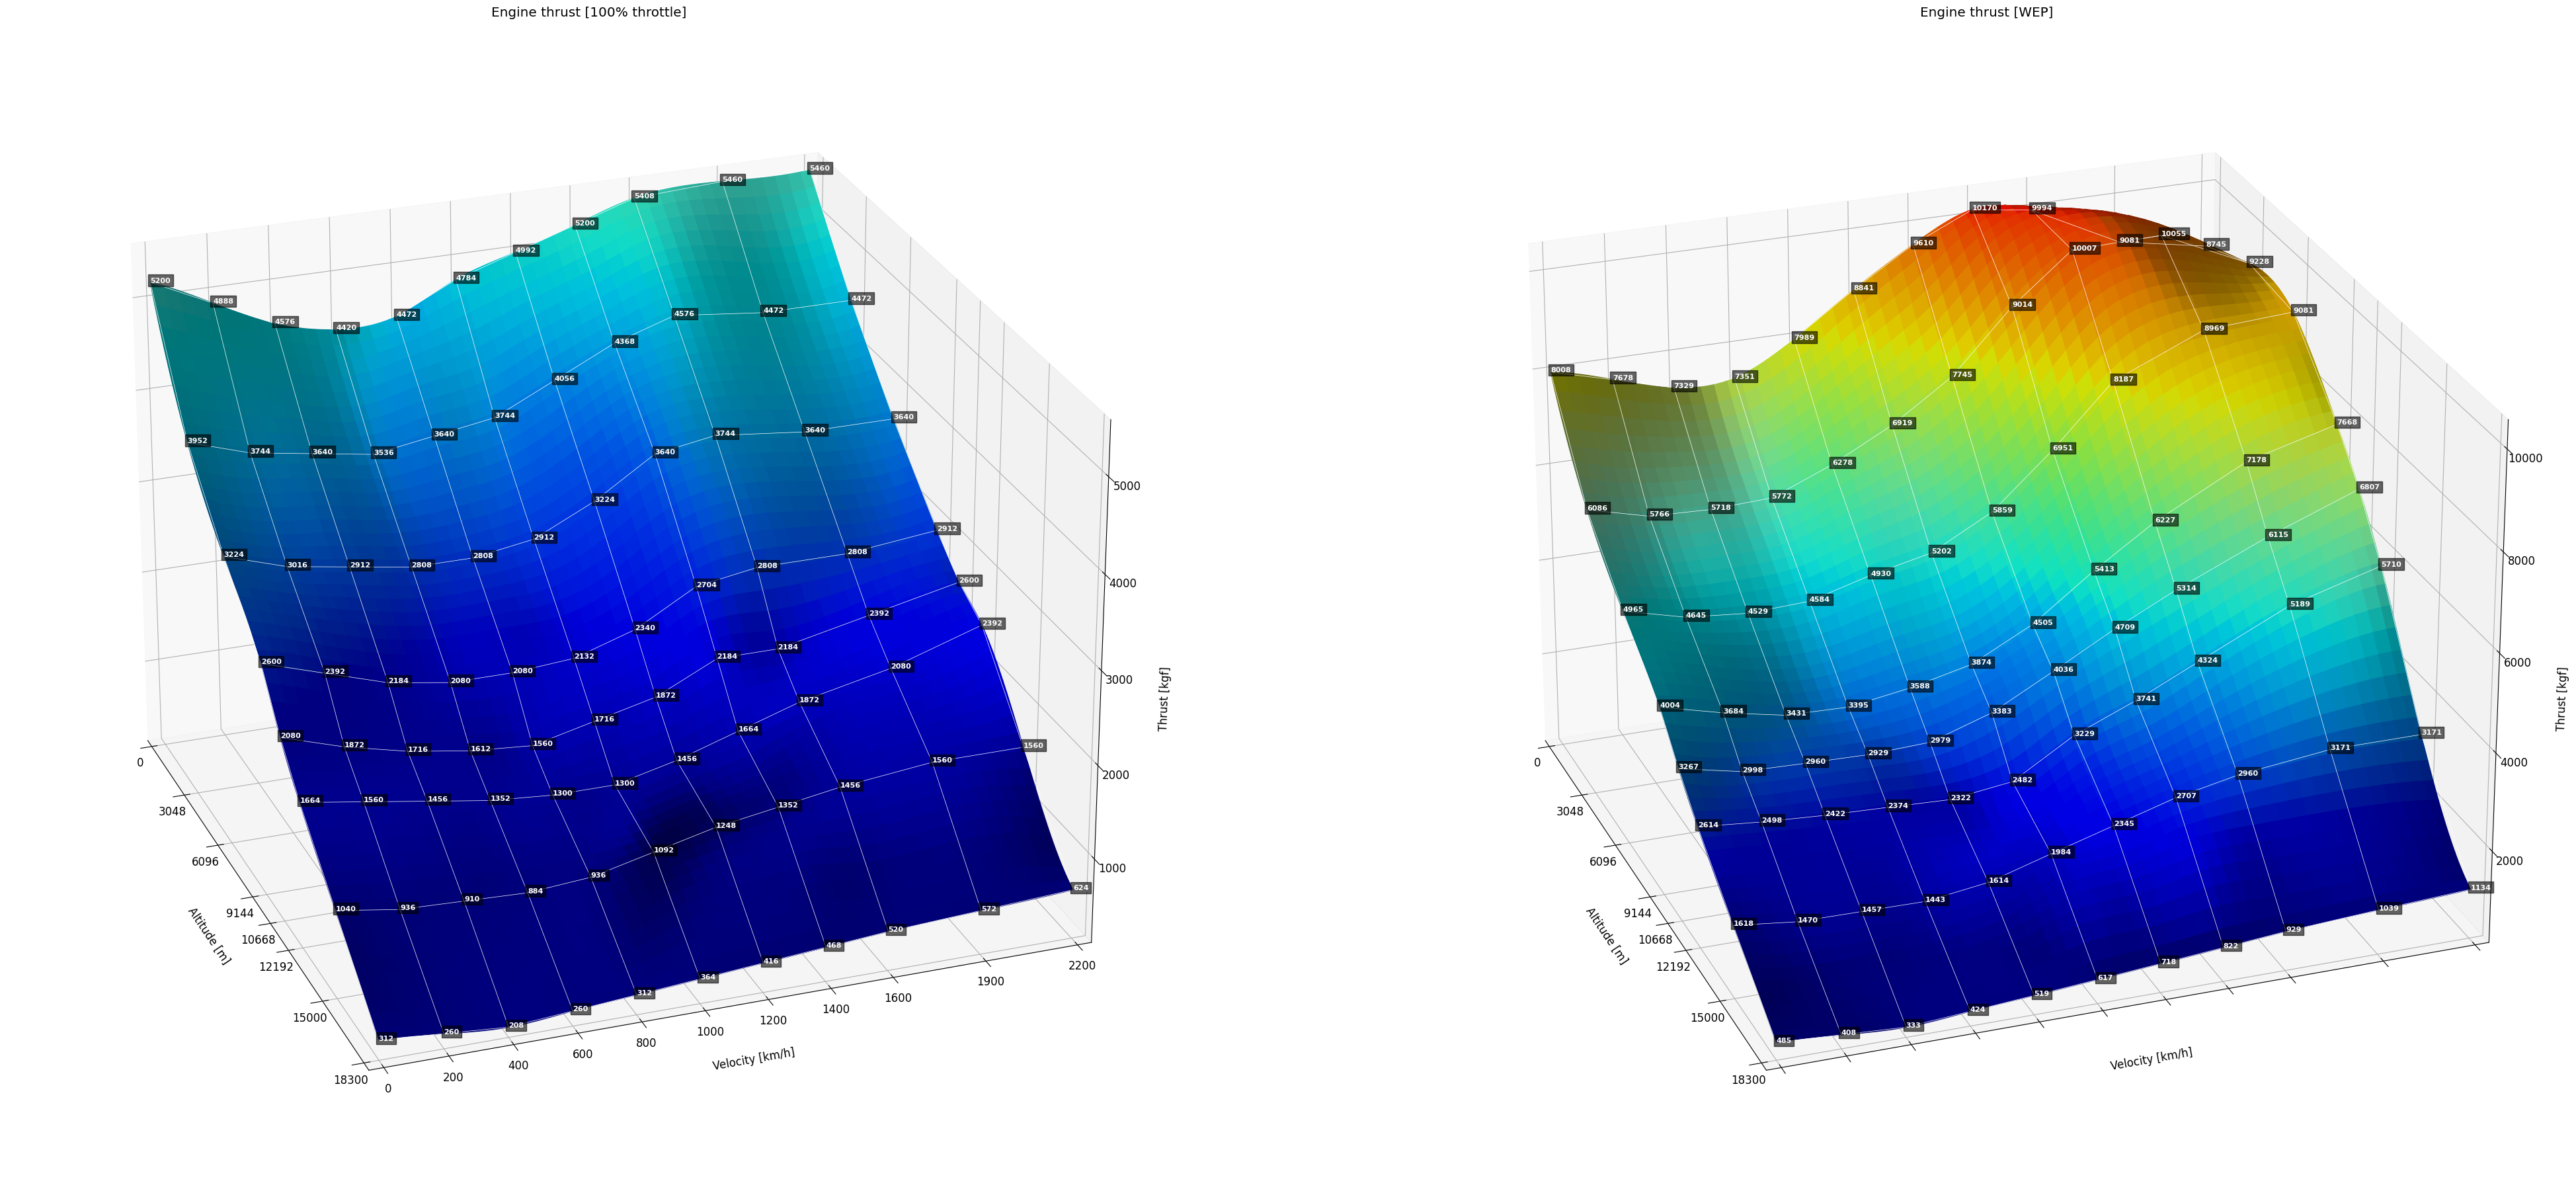

In [91]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LightSource
import scipy.interpolate as sp
import re
import json

filename = "f-4e.blkx"
title = "F-4E"

with open(f"./{filename}", "r") as f:
        global baseThrust # ThrustMax 0 from blkx
        global boostAfterburn # AfterburnerBoost from blk
        global boostWep # ThrustMult - mode with 110% throttle
        global boostNoWep # ThrustMult - mode with 100% throttle
        global alts # altitudes in meters from blkx
        global vels # velocities in kph from blkx
        global thrustCurve # actual thrust multipliers
        data = json.loads(f.read())
        engine = data["EngineType0"]["Main"]
        thrustData = engine["ThrustMax"]
        
        baseThrust = thrustData["ThrustMax0"]
        boostAfterburn = engine["AfterburnerBoost"]
        modes = list(filter(lambda x: re.match(r'Mode\d+', x) and engine[x]["Throttle"] >= 1.0, engine.keys()))
        
        boostNoWep = engine[modes[0]]["ThrustMult"]
        boostWep = engine[modes[-1]]["ThrustMult"]

        alts = [x[1] for x in list(filter(lambda x: re.match(r'Altitude_\d+', x[0]), thrustData.items()))]
        vels = [x[1] for x in list(filter(lambda x: re.match(r'Velocity_\d+', x[0]), thrustData.items()))]

        thrustCurve = np.zeros((len(alts), len(vels), 2))
        for (k,v) in thrustData.items():
                groups = re.match(r'(.*)_(\d+)_(\d+)', k) # regexp magic
                if(groups is None):
                        continue
                groups = groups.groups()
                dataType = groups[0]
                if dataType == "TorqueMaxCoeff": # we're not interested in torque, skip it
                        continue
                alt = int(groups[1])
                vel = int(groups[2])
                if dataType == "ThrustMaxCoeff":
                        thrustCurve[alt][vel][0] = v # set mul for 100% throttle
                elif dataType == "ThrAftMaxCoeff":
                        thrustCurve[alt][vel][1] = v # this is not final afterburner multiplier, it'll get multiplied by 100% mul
                                

alts2 = np.linspace(min(alts), max(alts), 200)
vels2 = np.linspace(min(vels), max(vels), 200)

xV, yV =  np.meshgrid(alts, vels) # map velocities to altitudes and altitudes to velocities so we can graph it

# some graph config
angs = (25, -20) # viewport angle (pitch, yaw)

cmap = plt.cm.jet # color spectrum for values
vMin = 1000 # color range minimum value
vMax = 12000 # color range maximum value
ls = LightSource(130, 40) # better light position

# interpolation
x2V, y2V = np.meshgrid(alts2, vels2)
interp100 = sp.interp2d(alts, vels, thrustCurve[:,:,0].flatten(), kind="cubic")
interpWEP = sp.interp2d(alts, vels, thrustCurve[:,:,1].flatten(), kind="cubic")
zVal100 = interp100(alts2, vels2)
zValWEP = interpWEP(alts2, vels2)

# prepare the graph
fig, ax = plt.subplots(ncols=2, subplot_kw={'projection': "3d"}, dpi=100, sharex=True, sharey=True, figsize=(50, 25))


# actual thrust calculation at 100% throttle
thrust100 = baseThrust * boostNoWep * (thrustCurve[:,:,0])
thrust100_interp = baseThrust * boostNoWep * (zVal100)

# shading for 100% throttle
rgb = ls.shade(thrust100_interp, cmap=cmap,  blend_mode='soft', vmin=vMin, vmax=vMax)

ax[0].plot_surface(x2V, y2V, thrust100_interp, facecolors=rgb, antialiased=True)
ax[0].plot_wireframe(xV, yV, thrust100.T, color="white", linewidth=0.5)
ax[0].set_title("Engine thrust [100% throttle]")
ax[0].set_xlabel("Altitude [m]")
ax[0].set_ylabel("Velocity [km/h]")
ax[0].set_zlabel("Thrust [kgf]")
ax[0].view_init(*angs)

# same but for WEP (110% throttle)
thrustWEP = baseThrust * boostAfterburn * boostWep * ((thrustCurve[:,:,0]*thrustCurve[:,:,1]))
thrustWEP_interp = baseThrust * boostAfterburn * boostWep * (zVal100*zValWEP)

# shading for WEP throttle
rgb2 = ls.shade(thrustWEP_interp, cmap=cmap, blend_mode='soft', vmin=vMin, vmax=vMax)

ax[1].plot_surface(x2V, y2V, thrustWEP_interp, facecolors=rgb2, antialiased=True)
ax[1].plot_wireframe(xV, yV, thrustWEP.T, color="white", linewidth=0.5)
ax[1].set_title("Engine thrust [WEP]")
ax[1].set_xlabel("Altitude [m]")
ax[1].set_ylabel("Velocity [km/h]")
ax[1].set_zlabel("Thrust [kgf]")
ax[1].view_init(*angs)

# font used in data point values
dataFont = {
        "backgroundcolor": (0, 0, 0, 0.6),
        "color": "white",
        "size": 8,
        "weight": 800,
}

# draw data points values so we know what are we working with
for i in range(thrustCurve[:,:,0].size):
        xVal = xV.T.flatten()[i]
        yVal = yV.T.flatten()[i]
        ax[0].text(xVal, yVal, thrust100.flatten()[i], "{:0.0f}".format(thrust100.flatten()[i]), zorder=1000, fontdict=dataFont)
        ax[1].text(xVal, yVal, thrustWEP.flatten()[i], "{:0.0f}".format(thrustWEP.flatten()[i]), zorder=1000, fontdict=dataFont)

# match x (alt) and y (vel) ticks to the blkx discrete values
ax[0].set_xticks(alts)
ax[1].set_xticks(alts)
ax[0].set_xlim(min(alts), max(alts))
ax[1].set_xlim(min(alts), max(alts))

ax[0].set_yticks(vels)
ax[1].set_yticks(vels)
ax[0].set_ylim(min(vels), max(vels))
ax[1].set_ylim(min(vels), max(vels))

# fix axis padding
ax[0].xaxis.labelpad = 20.0
ax[0].yaxis.labelpad = 20.0
ax[0].zaxis.labelpad = 20.0

ax[1].xaxis.labelpad = 20.0
ax[1].yaxis.labelpad = 20.0
ax[1].zaxis.labelpad = 20.0

# save to png
fig.savefig(f"{title}.png", facecolor="white", edgecolor='none', bbox_inches='tight')